Solución utilizando ```numpy```

### Transformando los datos con TSNE

In [1]:
import librosa
import librosa.display
import pathlib
from pathlib import Path
from transformers import AutoFeatureExtractor #generador de características
import torch
import numpy as np
np.random.seed(42) 

/Users/rodolfolobocarrasco/.pyenv/versions/3.11.6/envs/ambiente-audio-2023/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Cargando los audios

In [2]:
### Sample Rate
sr = 16000
### Camino para encontrar los datos
MyPath = pathlib.Path('/Users/rodolfolobocarrasco/Desktop/Audio_Machine_Learning/projects/proyecto_1/solution')

### Señales de bombo
kick_signals = [
    librosa.load(p, sr = sr)[0] for p in MyPath.glob('data/kick/Copia de Bass Sample *.wav')
]

### Señales de caja
snare_signals = [
    librosa.load(p, sr = sr)[0] for p in MyPath.glob('data/snare/Copia de Snare Sample *.wav')
]

In [3]:
print(f" Cantidad de audios de bombo procesados: {len(kick_signals)}")

 Cantidad de audios de bombo procesados: 40


In [4]:
print(f" Cantidad de audios de caja procesados: {len(kick_signals)}")

 Cantidad de audios de caja procesados: 40


### Caja Negra: extracción de características + reducción de dimensión

Cargando el modelo extractor de características

In [5]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

/Users/rodolfolobocarrasco/.pyenv/versions/3.11.6/envs/ambiente-audio-2023/lib/python3.11/site-packages/transformers/configuration_utils.py:381: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


### Extracción de Características

In [6]:
kick_inputs = feature_extractor(kick_signals, sampling_rate=sr, return_tensors="pt")
snare_inputs = feature_extractor(snare_signals, sampling_rate=sr, return_tensors="pt")

In [7]:
kick_embeddings = kick_inputs['input_values']
snare_embeddings = snare_inputs['input_values']

### Reduciendo la dimensión

In [8]:
X = torch.cat((kick_embeddings, snare_embeddings), 0)

In [9]:
from sklearn import manifold

In [10]:
tsne = manifold.TSNE(n_components = 2, random_state = 42)
transformed_data = tsne.fit_transform(X)

### Visualizando los datos

In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

Aqui ```kicks = 1``` y ```snares = 0```. Observe que exiten algunos valores anómalos, es decir, algunos sonidos de bombo que están dentro del cluster de caja y viceversa. 
Entrenemos el modelo para observar que ocurrirá

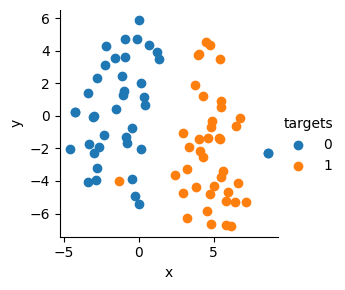

In [12]:
df_tsne = pd.DataFrame(transformed_data)
df_tsne['targets'] = 40*[1] + 40*[0]
df_tsne.columns = ['x','y','targets']
grid = sns.FacetGrid(df_tsne,hue = "targets")
grid.map(plt.scatter,"x","y").add_legend()

In [13]:
df_tsne

,x,y,targets
0,6.611866,-4.113020,1
1,5.500803,-3.785679,1
2,3.845456,-4.395586,1
3,5.514779,0.884576,1
4,5.434247,-1.393771,1
...,...,...,...
75,-4.257652,0.217296,0
76,-4.300358,0.234271,0
77,0.652963,4.368311,0
78,-1.594770,3.521643,0


### Cargando la clase perceptrón

In [14]:
import numpy as np
from perceptron import Perceptron

Inicializo el modelo 

In [15]:
### Inicializamos el modelo
mi_modelo = Perceptron(num_features = 2, learning_rate = 0.001)

Observemos los objetos generados dentro de la clase

In [16]:
mi_modelo.weights

array([0., 0., 0.])

### Entrenamos el modelo

### features

In [17]:
x = df_tsne[["x","y"]].to_numpy()

In [18]:
x.shape

(80, 2)

In [19]:
x[0]

array([ 6.6118665, -4.1130204], dtype=float32)

### targets

In [20]:
y =df_tsne[["targets"]].to_numpy()

In [21]:
y.shape[0]

80

### Entrenando el modelo

### 

In [22]:
mi_modelo.train(training_data = x,labels = y,epochs = 1000)

### Accuracy, evaluando sobre el conjunto de entrenamiento

Obtenemos un bajo valor de accuracy

In [23]:
mi_modelo.evaluate(x,y)

0.5

### Observamos los valores obtenidos por el modelo

In [24]:
weights_to_plot = mi_modelo.weights
print(f"pesos del modelo {weights_to_plot}")

pesos del modelo [-0.016      -0.00100682  0.00127413]


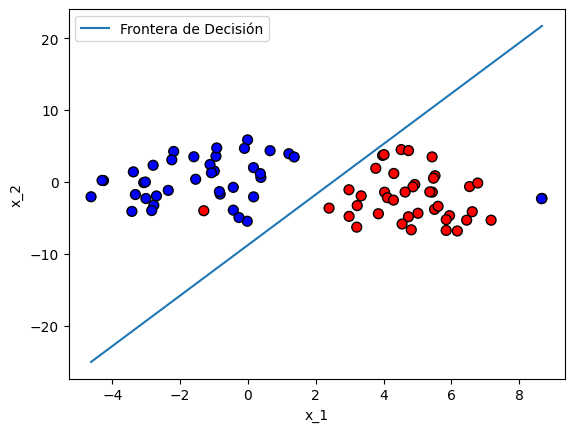

In [31]:
# Prepare the data
X = df_tsne[['x', 'y']].values
y = df_tsne['targets'].values

# Plot the data points
plt.scatter(df_tsne['x'], df_tsne['y'], c=df_tsne['targets'], cmap='bwr', edgecolor='k', s=50)
plt.xlabel('x_1')
plt.ylabel('x_2')

# Plot the decision boundary
x_values = np.linspace(df_tsne['x'].min(), df_tsne['x'].max(), 100)
y_values = -(mi_modelo.weights[1] * x_values + mi_modelo.weights[0]) / mi_modelo.weights[2]

plt.plot(x_values, y_values, label='Frontera de Decisión')
plt.legend()
plt.show()

### Removiendo outliers de los datos

COmo vimos en el caso anterior, algunos de nuestros ejemplos se escapan de lo usual y aparecen en las nubes de la clase contraria. Eliminemos esos ejemplos para poder tener una separabilidad lineal, tal y como aparece en las ideas del cuaderno. 

In [26]:
from scipy import stats

# Compute Z-scores
z_scores = np.abs(stats.zscore(df_tsne[['x', 'y']]))

# Define a threshold
threshold = 1.5

# Remove outliers
df_no_outliers = df_tsne[(z_scores < threshold).all(axis=1)]

df_no_outliers.shape

(64, 3)

In [27]:
x_no_outliers = df_no_outliers[["x","y"]].to_numpy()
y_no_outliers = df_no_outliers[["targets"]].to_numpy()

In [28]:
### Inicializamos el modelo
mi_modelo = Perceptron(num_features = 2, learning_rate = 0.001)
mi_modelo.train(training_data = x_no_outliers,labels = y_no_outliers,epochs = 1000)

In [29]:
mi_modelo.evaluate(x,y)

0.9625

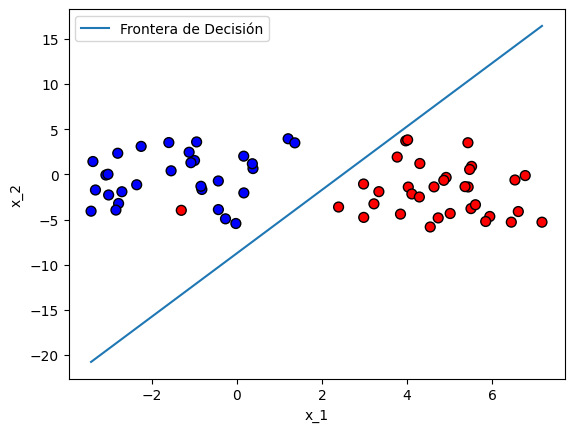

In [32]:
# Plot the data points
plt.scatter(df_no_outliers['x'], df_no_outliers['y'], c=df_no_outliers['targets'], cmap='bwr', edgecolor='k', s=50)
plt.xlabel('x_1')
plt.ylabel('x_2')

# Plot the decision boundary
x_values = np.linspace(df_no_outliers['x'].min(), df_no_outliers['x'].max(), 100)
y_values = -(mi_modelo.weights[1] * x_values + mi_modelo.weights[0]) / mi_modelo.weights[2]

plt.plot(x_values, y_values, label='Frontera de Decisión')
plt.legend()
plt.show()

Observe las diferencias que sufre la performance del modelo debido a la eliminación de los outliers!